# CNN Experiments

This week we will dive a bit deeper into GoogLeNet and ResNet, and implement versions of each. Both break with traditional convolutional nets. GoogLeNet uses "parallel" layers operating independently of each other that feed into the same output (inception modules).  ResNets feed information more than one layer forward 

## MiniGoogLeNet

Note for GoogLeNet, the inception modules are not exactly sequential, so we will need to define layers a little differently as we see below, after importing some packages. And, we use "miniception" modules as per *Understanding Deep Learning Requires Re-Thinking Generalization* (Zhang, et al., 2017 http://arxiv.org/abs/1611.03530), which work well for small-dimensional image datasets.

In [1]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import add
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import add
from tensorflow.keras import backend

In [2]:
class MiniGoogLeNet:
    def convolution_module(x, K, kX, kY, stride, channelsDim, padding="same"):
        # create a CONV -> BN -> RELU sequence
        x = Conv2D(K, (kX, kY), strides = stride, padding = padding)(x)
        x = BatchNormalization(axis = channelsDim)(x)
        x = Activation('relu')(x)
        
        # return the output
        return x
    
    def inception_module(x, numberOf1x1Kernels, numberOf3x3Kernels, channelsDim):
        # define two "parallel" convolutions of size 1x1 and 3x3 concatenated across the channels dimension
        convolution_1x1 = MiniGoogLeNet.convolution_module(x, numberOf1x1Kernels, 1, 1, (1, 1), channelsDim)
        convolution_3x3 = MiniGoogLeNet.convolution_module(x, numberOf3x3Kernels, 3, 3, (1, 1), channelsDim)
        x = concatenate([convolution_1x1, convolution_3x3], axis = channelsDim)
        
        return x
        
    def downsample_module(x, K, channelsDim):
        # define a CONV and POOL and then concatenate across the channels dimension
        convolution_3x3 = MiniGoogLeNet.convolution_module(x, K, 3, 3, (2, 2), channelsDim, padding = 'valid')
        pool = MaxPooling2D((3, 3), strides = (2, 2))(x)
        x = concatenate([convolution_3x3, pool], axis = channelsDim)
        
        return x
    
    def build(width, height, depth, classes):
        inputShape = (height, width, depth)
        channelsDim = -1
        
        if backend.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            channelsDim = 1
        
        # define the model input and first CONV module
        inputs = Input(shape = inputShape)
        x = MiniGoogLeNet.convolution_module(inputs, 96, 3, 3, (1, 1), channelsDim)
        
        # two inception modules followed by a downsample module
        x = MiniGoogLeNet.inception_module(x, 32, 32, channelsDim)
        x = MiniGoogLeNet.inception_module(x, 32, 48, channelsDim)
        x = MiniGoogLeNet.downsample_module(x, 80, channelsDim)
        
        # four inception modules followed by a downsample module
        x = MiniGoogLeNet.inception_module(x, 112, 48, channelsDim)
        x = MiniGoogLeNet.inception_module(x, 96, 64, channelsDim)
        x = MiniGoogLeNet.inception_module(x, 80, 80, channelsDim)
        x = MiniGoogLeNet.inception_module(x, 48, 96, channelsDim)
        x = MiniGoogLeNet.downsample_module(x, 96, channelsDim)
        
        # two inception modules followed by global POOL and dropout
        x = MiniGoogLeNet.inception_module(x, 176, 160, channelsDim)
        x = MiniGoogLeNet.inception_module(x, 176, 160, channelsDim)
        x = AveragePooling2D((7, 7))(x)
        x = Dropout(0.5)(x)
        
        # softmax classifier
        x = Flatten()(x)
        x = Dense(classes)(x)
        x = Activation('softmax')(x)
        
        # create a model
        model = Model(inputs, x, name='MiniGoogLeNet')
        
        # return the model
        return model

### MiniGoogLeNet on CIFAR-10

Let's test it on CIFAR-10

In [3]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import cifar10
import numpy as np
import os

from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [5]:
numberOfEpochs = 70
initialLearningRate = 0.005

def polynomial_decay(epoch):
    maxEpochs = numberOfEpochs
    baseLearningRate = initialLearningRate
    power = 1.0
    
    alpha = baseLearningRate * (1 - (epoch / float(numberOfEpochs))) ** power
    
    # return the learning rate
    return alpha
    
# load cifar10 data
((trainX, trainY), (testX, testY)) = cifar10.load_data()
trainX = trainX.astype('float')
testX = testX.astype('float')

# use mean subtraction
mean = np.mean(trainX, axis = 0)
trainX -= mean
testX -= mean

# convert labels to one-hot
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

callbacks = [LearningRateScheduler(polynomial_decay)]

print('[INFO] compiling model...')
opt = SGD(lr = initialLearningRate, momentum=0.9)
model = MiniGoogLeNet.build(width = 32, height = 32, depth = 3, classes = 10)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics=["accuracy"])

# print a model summary
print(model.summary())

# train the network
print("[INFO] training network...")
H = model.fit(trainX, trainY, validation_data = (testX, testY), batch_size = 64, epochs = numberOfEpochs,
              callbacks = callbacks, verbose = 1)

# save the network to disk
#print("[INFO] serializing network...")
#model.save('output/MiniGoogLeNet_cifar10.hdf5')

# print a classification report
print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY, digits=4))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, numberOfEpochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, numberOfEpochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, numberOfEpochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, numberOfEpochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

[INFO] compiling model...
Model: "MiniGoogLeNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 32, 32, 96)   2688        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 32, 32, 96)   384         conv2d_19[0][0]                  
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 32, 32, 96)   0           batch_normalization_19[0][0]     
____________________________________________________________

This results in 85% accuracy, which is pretty good, but it seems to be overfitting.

### GoogLeNet Experiment 2: Data Augmentation

Let's see if data augmentation helps with the overfitting problem.

In [3]:
numberOfEpochs = 70
initialLearningRate = 0.005

def polynomial_decay(epoch):
    maxEpochs = numberOfEpochs
    baseLearningRate = initialLearningRate
    power = 1.0
    
    alpha = baseLearningRate * (1 - (epoch / float(numberOfEpochs))) ** power
    
    # return the learning rate
    return alpha
    
# load cifar10 data
((trainX, trainY), (testX, testY)) = cifar10.load_data()
trainX = trainX.astype('float')
testX = testX.astype('float')

# use mean subtraction
mean = np.mean(trainX, axis = 0)
trainX -= mean
testX -= mean

# convert labels to one-hot
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

# construct the image generator for data augmentation
aug = ImageDataGenerator(width_shift_range = 0.1, height_shift_range = 0.1,
                         horizontal_flip = True, fill_mode="nearest")

callbacks = [LearningRateScheduler(polynomial_decay)]

print('[INFO] compiling model...')
opt = SGD(lr = initialLearningRate, momentum=0.9)
model = MiniGoogLeNet.build(width = 32, height = 32, depth = 3, classes = 10)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics=["accuracy"])

# train the network
print("[INFO] training network...")

H = model.fit(aug.flow(trainX, trainY, batch_size=64), validation_data=(testX, testY),
              steps_per_epoch=len(trainX) // 64, epochs=numberOfEpochs, callbacks = callbacks, verbose=1)

# print a model summary
print(model.summary())

# print a classification report
print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY, digits=4))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, numberOfEpochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, numberOfEpochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, numberOfEpochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, numberOfEpochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

[INFO] compiling model...
[INFO] training network...
  ...
    to  
  ['...']
Train for 781 steps, validate on 10000 samples
Epoch 1/70
781/781 [==============================] - 36s 46ms/step - loss: 1.4885 - accuracy: 0.4570 - val_loss: 1.3241 - val_accuracy: 0.5350
Epoch 2/70
781/781 [==============================] - 46s 58ms/step - loss: 1.0807 - accuracy: 0.6133 - val_loss: 1.0269 - val_accuracy: 0.6423
Epoch 3/70
781/781 [==============================] - 47s 60ms/step - loss: 0.8980 - accuracy: 0.6833 - val_loss: 1.2337 - val_accuracy: 0.5979
Epoch 4/70
781/781 [==============================] - 287s 368ms/step - loss: 0.7859 - accuracy: 0.7247 - val_loss: 0.8290 - val_accuracy: 0.7109
Epoch 5/70
781/781 [==============================] - 38s 49ms/step - loss: 0.7043 - accuracy: 0.7562 - val_loss: 0.9168 - val_accuracy: 0.7040
Epoch 6/70
781/781 [==============================] - 32s 40ms/step - loss: 0.6400 - accuracy: 0.7788 - val_loss: 0.7356 - val_accuracy: 0.7498
Epoch 7/7

We've now cracked 90% for the first time with CIFAR-10!

## ResNet

Let's implement a ResNet next. We will write a function to create residual modules first and then iteratively construct the architecture to save some repetition.

In [4]:
class ResNet:
    def residual_module(data, K, stride, channelsDim, reduce = False, reg = 0.0001, bnEpsilon = 0.00002, bnMomentum = 0.9):
        shortcut = data
        
        # 1x1 CONVs
        bn1 = BatchNormalization(axis = channelsDim, epsilon = bnEpsilon, momentum = bnMomentum)(data)
        act1 = Activation('relu')(bn1)
        conv1 = Conv2D(int(K * 0.25), (1, 1), use_bias = False, kernel_regularizer = l2(reg))(act1)
        
        # 3x3 CONVs
        bn2 = BatchNormalization(axis = channelsDim, epsilon = bnEpsilon, momentum = bnMomentum)(conv1)
        act2 = Activation('relu')(bn2)
        conv2 = Conv2D(int(K * 0.25), (3, 3), strides = stride, padding = 'same', use_bias = False, kernel_regularizer = l2(reg))(act2)
        
        # 1x1 CONVs
        bn3 = BatchNormalization(axis = channelsDim, epsilon = bnEpsilon, momentum = bnMomentum)(conv2)
        act3 = Activation('relu')(bn3)
        conv3 = Conv2D(K, (1, 1), use_bias = False, kernel_regularizer = l2(reg))(act3)
        
        # if we reduce the spatial size, apply a CONV layer to the shortcut
        if reduce:
            shortcut = Conv2D(K, (1, 1), strides = stride, use_bias = False, kernel_regularizer = l2(reg))(act1)
            
        # add the shortcut and the final CONV
        x = add([conv3, shortcut])
        
        return x
    
    def build(width, height, depth, classes, stages, filters, reg = 0.0001, bnEpsilon = 0.00002, bnMomentum = 0.9, dataset='cifar'):
        inputShape = (height, width, depth)
        channelsDim = -1
        
        if backend.image_data_format() == 'channels_first':
            inputShape = (depth, height, width)
            channelsDim = 1
            
        # set the input and apply BN
        inputs = Input(shape = inputShape)
        x = BatchNormalization(axis = channelsDim, epsilon = bnEpsilon, momentum = bnMomentum)(inputs)
        
        if dataset == 'cifar':
            # apply a single CONV layer
            x = Conv2D(filters[0], (3, 3), use_bias = False, padding = 'same',
                       kernel_regularizer = l2(reg))(x)
        
        # loop over the number of stages
        for counter in range(0, len(stages)):
            # initialize the stride
            if counter == 0:
                stride = (1, 1)
            else:
                stride = (2, 2)
                    
            # apply a residual module to reduce the spatial dimension of the image volume
            x = ResNet.residual_module(x, filters[counter + 1], stride, channelsDim, reduce = True, bnEpsilon = bnEpsilon, bnMomentum = bnMomentum)
            
            # loop over the number of layers in the current stage
            for j in range(0, stages[counter] - 1):
                # apply a residual module
                x = ResNet.residual_module(x, filters[counter + 1], (1, 1), channelsDim, bnEpsilon = bnEpsilon, bnMomentum = bnMomentum)
                    
        # apply BN -> ACT -> POOL
        x = BatchNormalization(axis = channelsDim, epsilon = bnEpsilon, momentum = bnMomentum)(x)
        x = Activation('relu')(x)
        x = AveragePooling2D((8, 8))(x)
        
        # softmax classifier
        x = Flatten()(x)
        x = Dense(classes, kernel_regularizer = l2(reg))(x)
        x = Activation('softmax')(x)
        
        # create the model
        model = Model(inputs, x, name = 'ResNet')
        
        # return the model
        return model

### ResNet on CIFAR-10

Let's test it on CIFAR-10, this time with data augmentation from the start.

[INFO] loading CIFAR-10 data...
[INFO] compiling model...
Model: "ResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 3)    12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   1728        batch_normalization[0][0]        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 64)   256         conv2d[0][0]                     
___________________________________

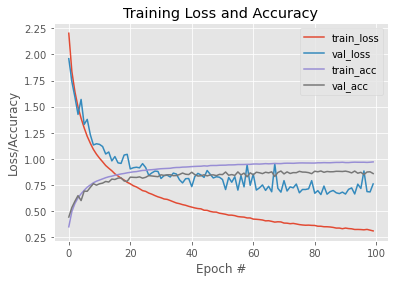

In [4]:
# load the training and testing data
print("[INFO] loading CIFAR-10 data...")
((trainX, trainY), (testX, testY)) = cifar10.load_data()
trainX = trainX.astype("float")
testX = testX.astype("float")

# apply mean subtraction to the data
mean = np.mean(trainX, axis=0)
trainX -= mean
testX -= mean

# convert the labels from integers to vectors
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

aug = ImageDataGenerator(width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True, fill_mode="nearest")

print("[INFO] compiling model...")
opt = SGD(lr = 0.1)
model = ResNet.build(32, 32, 3, 10, (9, 9, 9), (64, 64, 128, 256), reg=0.0005)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics=['accuracy'])

# print a model summary
print(model.summary())

print("[INFO] training network...")
H = model.fit(aug.flow(trainX, trainY, batch_size=128), validation_data=(testX, testY),
              steps_per_epoch=len(trainX) // 128, epochs=100, verbose=1)

# print a classification report
print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY, digits=4))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 100), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 100), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

### ResNet Experiment 2: Data Augmentation and a Learning Rate Scheduler

[INFO] loading CIFAR-10 data...
[INFO] compiling model...
[INFO] training network...
  ...
    to  
  ['...']
Train for 390 steps, validate on 10000 samples
Epoch 1/100
390/390 [==============================] - 62s 160ms/step - loss: 2.2054 - accuracy: 0.3525 - val_loss: 1.9545 - val_accuracy: 0.4573
Epoch 2/100
390/390 [==============================] - 50s 129ms/step - loss: 1.8504 - accuracy: 0.4976 - val_loss: 1.7733 - val_accuracy: 0.5244
Epoch 3/100
390/390 [==============================] - 50s 129ms/step - loss: 1.6691 - accuracy: 0.5634 - val_loss: 1.6154 - val_accuracy: 0.5886
Epoch 4/100
390/390 [==============================] - 51s 130ms/step - loss: 1.5205 - accuracy: 0.6220 - val_loss: 1.5732 - val_accuracy: 0.6077
Epoch 5/100
390/390 [==============================] - 51s 130ms/step - loss: 1.4065 - accuracy: 0.6630 - val_loss: 1.5530 - val_accuracy: 0.6298
Epoch 6/100
390/390 [==============================] - 51s 130ms/step - loss: 1.3090 - accuracy: 0.6994 - val_los

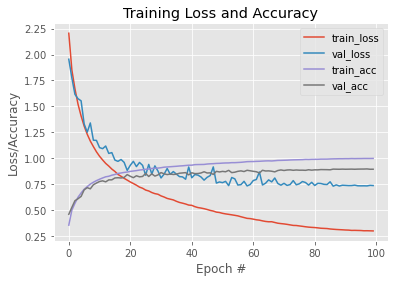

In [6]:
numberOfEpochs = 100
initialLearningRate = 0.1

# load the training and testing data
print("[INFO] loading CIFAR-10 data...")
((trainX, trainY), (testX, testY)) = cifar10.load_data()
trainX = trainX.astype("float")
testX = testX.astype("float")

# apply mean subtraction to the data
mean = np.mean(trainX, axis=0)
trainX -= mean
testX -= mean

# convert the labels from integers to vectors
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

aug = ImageDataGenerator(width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True, fill_mode="nearest")

print("[INFO] compiling model...")
opt = SGD(lr = initialLearningRate)
model = ResNet.build(32, 32, 3, 10, (9, 9, 9), (64, 64, 128, 256), reg=0.0005)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics=['accuracy'])

# print a model summary
#print(model.summary())

print("[INFO] training network...")

# code for a learning rate scheduler
def polynomial_decay(epoch):
    maxEpochs = numberOfEpochs
    baseLearningRate = initialLearningRate
    power = 1.0
    
    alpha = baseLearningRate * (1 - (epoch / float(numberOfEpochs))) ** power
    
    # return the learning rate
    return alpha

callbacks = [LearningRateScheduler(polynomial_decay)]

H = model.fit(aug.flow(trainX, trainY, batch_size=128), validation_data=(testX, testY),
              steps_per_epoch=len(trainX) // 128, epochs=numberOfEpochs, callbacks = callbacks, verbose=1)

# print a classification report
print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY, digits=4))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, numberOfEpochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, numberOfEpochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, numberOfEpochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, numberOfEpochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

[INFO] loading CIFAR-10 data...
[INFO] compiling model...
[INFO] training network...
  ...
    to  
  ['...']
Train for 390 steps, validate on 10000 samples
Epoch 1/100
390/390 [==============================] - 70s 180ms/step - loss: 2.1935 - accuracy: 0.3567 - val_loss: 2.0183 - val_accuracy: 0.4486
Epoch 2/100
390/390 [==============================] - 58s 149ms/step - loss: 1.8222 - accuracy: 0.5068 - val_loss: 1.8062 - val_accuracy: 0.5114
Epoch 3/100
390/390 [==============================] - 58s 148ms/step - loss: 1.6449 - accuracy: 0.5750 - val_loss: 1.8068 - val_accuracy: 0.5268
Epoch 4/100
390/390 [==============================] - 60s 153ms/step - loss: 1.5023 - accuracy: 0.6272 - val_loss: 1.4579 - val_accuracy: 0.6419
Epoch 5/100
390/390 [==============================] - 60s 154ms/step - loss: 1.3948 - accuracy: 0.6677 - val_loss: 1.4275 - val_accuracy: 0.6598
Epoch 6/100
390/390 [==============================] - 61s 158ms/step - loss: 1.3090 - accuracy: 0.6975 - val_los

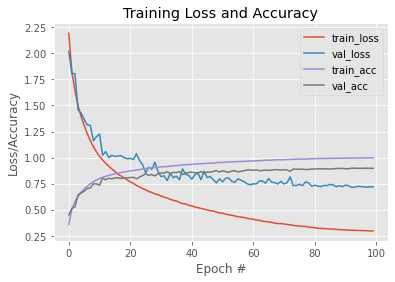

In [5]:
numberOfEpochs = 100
initialLearningRate = 0.1

# load the training and testing data
print("[INFO] loading CIFAR-10 data...")
((trainX, trainY), (testX, testY)) = cifar10.load_data()
trainX = trainX.astype("float")
testX = testX.astype("float")

# apply mean subtraction to the data
mean = np.mean(trainX, axis=0)
trainX -= mean
testX -= mean

# convert the labels from integers to vectors
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

aug = ImageDataGenerator(width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True, fill_mode="nearest")

print("[INFO] compiling model...")
opt = SGD(lr = initialLearningRate)
model = ResNet.build(32, 32, 3, 10, (9, 9, 9), (64, 64, 128, 256), reg=0.0005)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics=['accuracy'])

# print a model summary
#print(model.summary())

print("[INFO] training network...")

# code for a learning rate scheduler
def polynomial_decay(epoch):
    maxEpochs = numberOfEpochs
    baseLearningRate = initialLearningRate
    power = 1.0
    
    alpha = baseLearningRate * (1 - (epoch / float(numberOfEpochs))) ** power
    
    # return the learning rate
    return alpha

callbacks = [LearningRateScheduler(polynomial_decay)]

H = model.fit(aug.flow(trainX, trainY, batch_size=128), validation_data=(testX, testY),
              steps_per_epoch=len(trainX) // 128, epochs=numberOfEpochs, callbacks = callbacks, verbose=1)

# print a classification report
print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY, digits=4))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, numberOfEpochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, numberOfEpochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, numberOfEpochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, numberOfEpochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

Results are good but a little underwhelming here--according to Identity Mappings in Deep Residual Networks (He et. al., 2016, https://arxiv.org/abs/1603.05027), a similar approach can reach about 94% accuracy.